In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

import matplotlib.cm as cm

from math import *

from MITgcmutils import rdmds

from mpl_toolkits.mplot3d.axes3d import Axes3D

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns



In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import MetricsPythonTools as mpt

#lib_path = os.path.abspath('/Users/anakarinarm/SubmarineCanyonsResearch/PythonModulesMITgcm') # Add absolute path to my python scripts

#sys.path.append(lib_path)

#import ReadOutTools_MITgcm as rout 


In [3]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [4]:
#Base case, iso =1 , No 3d diff.
#CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

Ptracer3D='/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05/ptracersGlob.nc'
PtracerOut3D = Dataset(Ptracer3D)



In [5]:
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
bathy = rout.getField(CanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

z = CanyonStateOut.variables['Z']



In [6]:
Tr1 = rout.getField(Ptracer3D,'Tr1') # 


## Isopycnal surfaces

In [7]:
phiHyd = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05/phiHydGlob.nc'
pout = Dataset(phiHyd)

Temp = rout.getField(CanyonState,'Temp')
S = rout.getField(CanyonState,'S')

phiHydOut = Dataset(phiHyd)
P = phiHydOut.variables['phiHyd']
#P = rout.getField(phiHyd,'phiHyd')


In [8]:
RhoRef = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/RhoRef'))

depth = bathy

nzlim = 30

g = 9.81 # ms^-2

maskExp = mpt.maskExpand(MaskC,Tr1)

TempMask=np.ma.array(Temp,mask=maskExp)   
SMask=np.ma.array(S,mask=maskExp)   


/ocean/kramosmu/MITgcm/TracerExperiments/BARKLEY/run02/RhoRef.meta


In [9]:
# Calculate density and N

alpha = 1.7E-4/237 # 1/degC
beta = 7.6E-4

#Linear eq. of state 
rho = RhoRef[30]*(np.ones(np.shape(TempMask[:,:50,:,:])) - alpha*(TempMask[:,:50,:,:]) + beta*(SMask[:,:50,:,:]))


In [10]:
# Find max density on shelf
maxRho = np.max (rho[:,:30,227,:])
maxRho

1024.3585971268658

(24.354355316361307, -195.0)


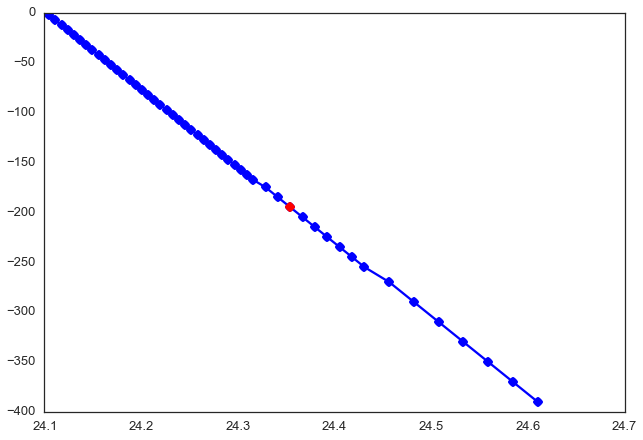

In [11]:
plt.plot(rho[0,:,227,180]-1000,z[:50],'bo-')
plt.plot(rho[0,36,227,180]-1000,z[36],'ro-')

print(rho[0,36,227,180]-1000,z[36])

In [12]:
densDepths = np.empty((19,360,360))
    
for tt in range(18):
    DensInd = np.argmax(rho[tt,:,:,:]>=maxRho,axis=0) 
    for i in range(360):
        for j in range(360):
            densDepths[tt,i,j] = z[DensInd[i,j]]

print(np.shape(densDepths))
DensDepthsMasked = np.ma.masked_values(densDepths,-2.5)
densDepths[np.where(np.ma.getmask(DensDepthsMasked)==True)] = np.nan

    


(19, 360, 360)


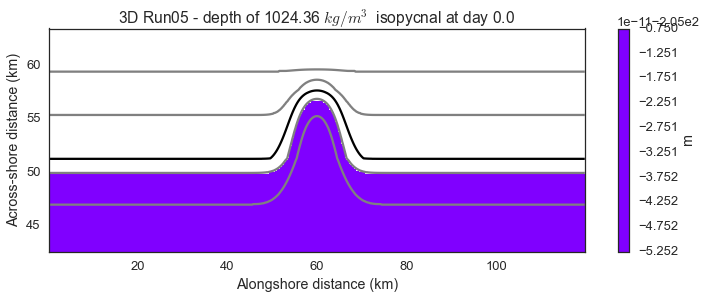

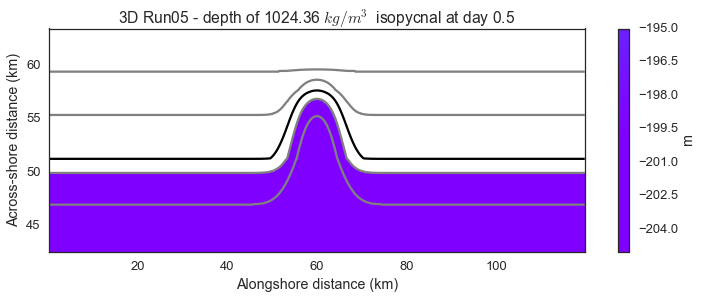

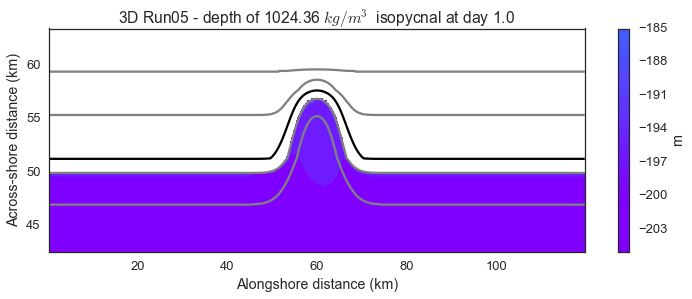

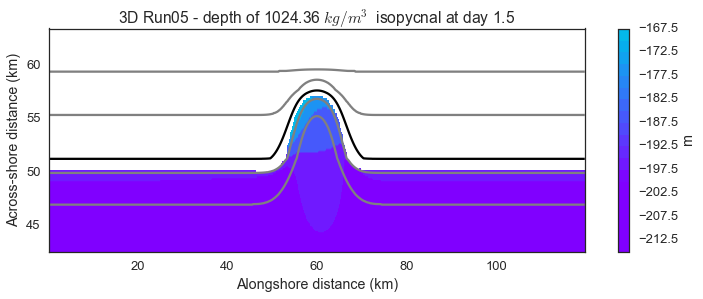

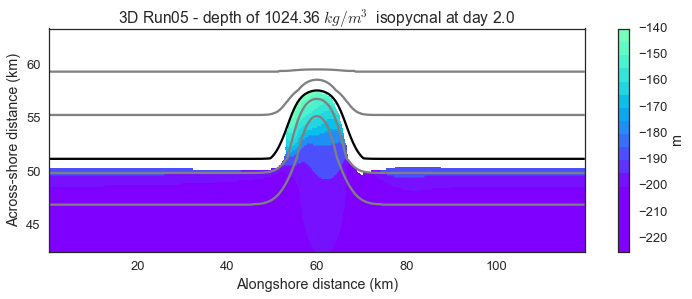

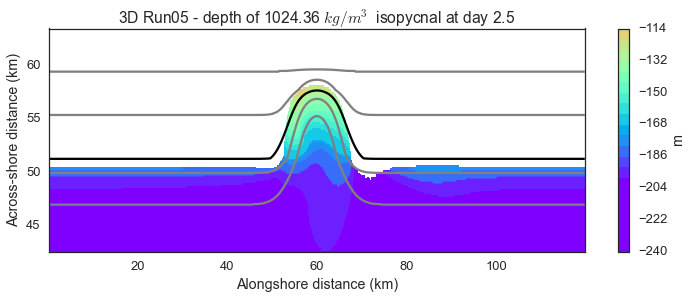

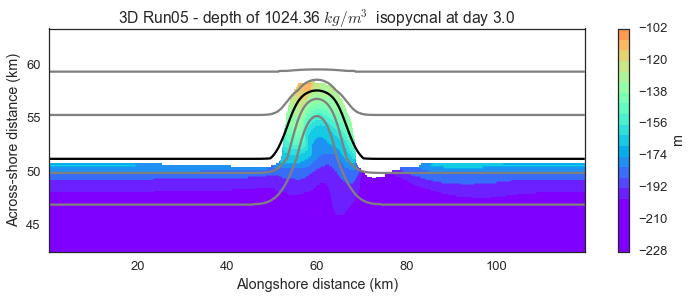

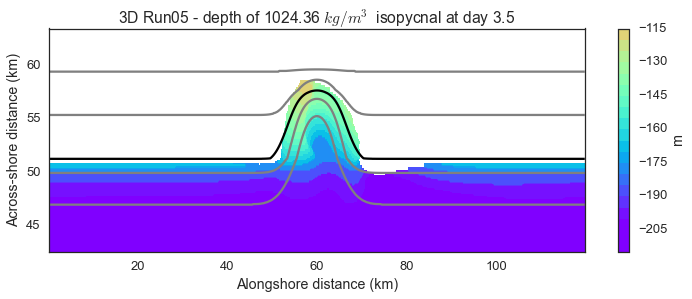

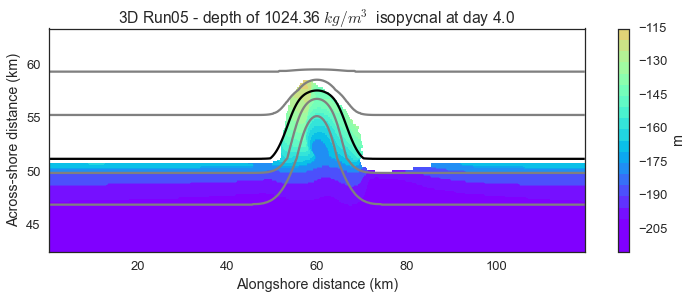

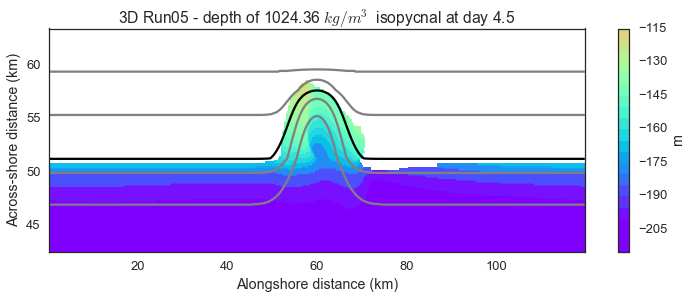

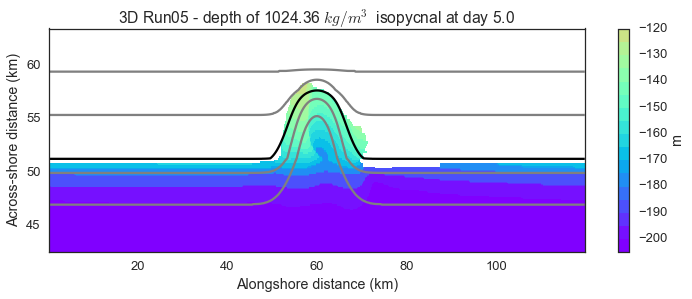

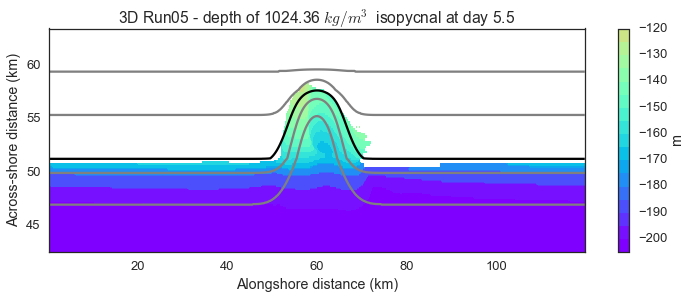

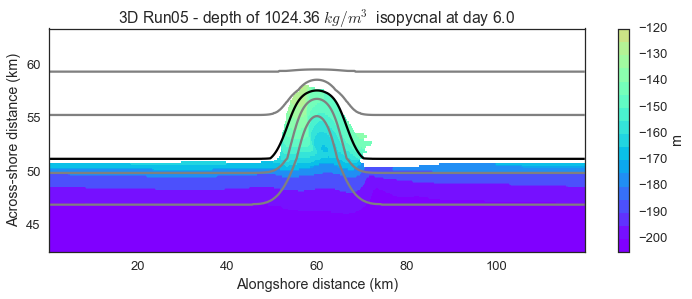

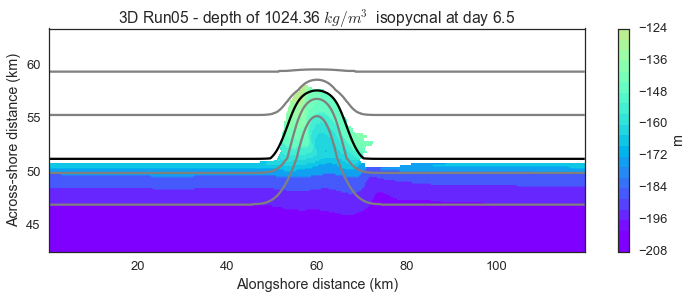

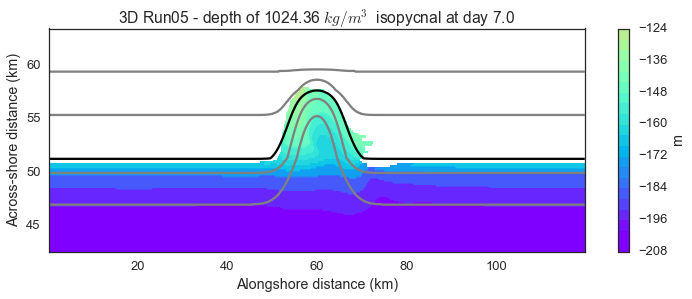

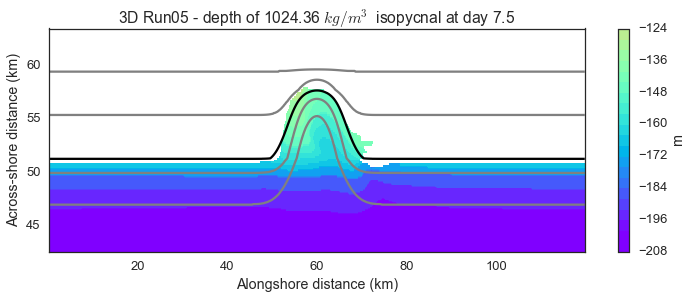

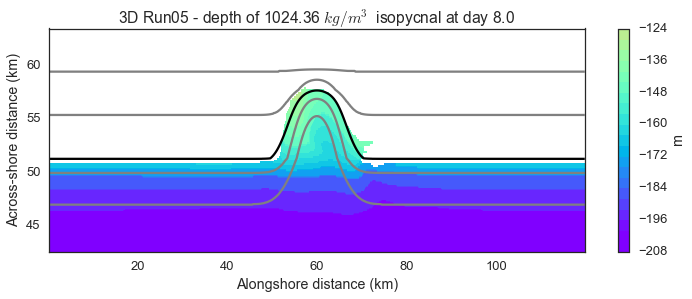

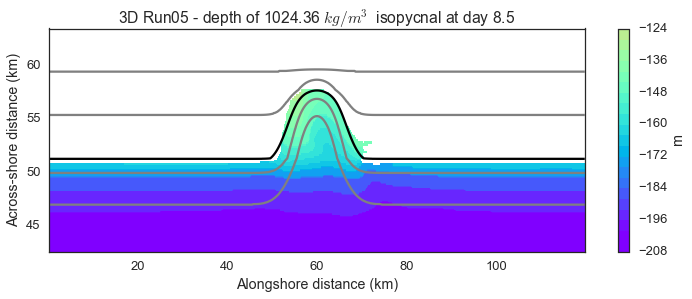

In [13]:
plt.rcParams['contour.negative_linestyle'] = 'solid' # default is to have negative contours with dashed lines
plt.rcParams.update({'font.size':20})


for tt in range(18):
    fig,((ax1)) = plt.subplots(1, 1, figsize=(12,4 ))

    iso = ax1.contourf(xc[160:-75,:]/1000.0,yc[160:-75,:]/1000.0,densDepths[tt,160:-75,:],20,cmap='rainbow',vmin=-200,vmax=-80)
    cb = fig.colorbar(iso, shrink=1,ax=ax1)

    cb.set_label('m')
    cset = ax1.contour(xc[160:-75,:]/1000.0,yc[160:-75,:]/1000.0,-bathy[160:-75,:],[-300,-200, rc[30],-125,-100,-75,-50],colors=['0.50','0.50','k','0.50','0.50','0.50','0.50'],linewidth=1, rstride=2, cstride=2,zdir='z')

    ax1.set_aspect('auto')
    plt.title('3D Run05 - depth of %1.2f $kg/m^3$ isopycnal at day %0.1f ' %( maxRho,tt/2.0))
    plt.ylabel('Across-shore distance (km)')
    plt.xlabel('Alongshore distance (km)')
    
      
    plt.show()

#fig.save

From this plots, the depth of upwelling (difference in depths of the deepest isopycnal that can be found on the shelf) is 90 m.